# Fact checking

In [1]:
import os
import requests
import zipfile
import re
import string
import random
from collections import namedtuple
from functools import partial

import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from tqdm.notebook import tqdm

import utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
nltk.download('tagsets')

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


True

In [3]:
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.xmargin'] = .05
plt.rcParams['axes.ymargin'] = .05
plt.style.use('ggplot')

## Dataset pre-processing

In [5]:
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk:
                f.write(chunk)


def download_data(data_path):
    toy_data_path = os.path.join(data_path, "fever_data.zip")
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(
                toy_url, params={"id": toy_data_url_id}, stream=True
            )
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

In [6]:
dataset_folder = os.path.join("datasets", "fever")
download_data(dataset_folder)

## Dataset conversion

In [7]:
dfs = []
for split in ["train", "test", "val"]:
    split_file = os.path.join(dataset_folder, f"{split}_pairs.csv")
    if os.path.isfile(split_file):
        split_df = pd.read_csv(split_file, index_col=0)
        split_df["split"] = pd.Series([split] * len(split_df), index=split_df.index)
        dfs.append(split_df)

df = pd.concat(dfs)
df.columns = map(str.lower, df.columns)
df = df.reset_index(drop=True)
df.head()

,claim,evidence,id,label,split
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS,train
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS,train
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES,train
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS,train
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES,train


In [8]:
df["label"].unique()

array(['SUPPORTS', 'REFUTES'], dtype=object)

In [9]:
print(f'Training set shape: {df[df["split"] == "train"].shape}')
print(f'Validation set shape: {df[df["split"] == "val"].shape}')
print(f'Test set shape: {df[df["split"] == "test"].shape}')

Training set shape: (121740, 5)
Validation set shape: (7165, 5)
Test set shape: (7189, 5)


In [10]:
TAB_CHAR = "\t"
PERIOD_CHAR = "."
LEFT_PARENS = "-LRB-"
RIGHT_PARENS = "-RRB-"
SQUARE_BRACKETS = r"-LSB-.*-RSB-"


def preprocess_claim(text):
    if text[-1] in string.punctuation:
        text = text[:-1]
    return text.strip().lower()


def preprocess_evidence(text):
    # Remove everything before the first tab character
    text = text[text.find(TAB_CHAR) + len(TAB_CHAR) :]
    # Replace tabs with spaces
    text = text.replace(TAB_CHAR, " ")
    # Remove parenthesis
    text = text.replace(LEFT_PARENS, " ").replace(RIGHT_PARENS, " ")
    # Remove everything between square brackets
    text = re.sub(SQUARE_BRACKETS, "", text)
    # Remove everything after the last period
    last_period = text.rfind(PERIOD_CHAR)
    if last_period is not None:
        text = text[:last_period]
    # Remove punctuation
    text = text.translate(text.maketrans("", "", string.punctuation))
    # Remove extra whitespaces
    text = " ".join(text.split())
    # Convert to lowercase
    return text.lower()

In [11]:
random_index = random.choice(df.index.tolist())
random_evidence = df.loc[random_index]["evidence"]
preprocessed_random_evidence = preprocess_evidence(random_evidence)
print(f"Random evidence {random_index}")
print(f"{random_evidence}")
print(f"{preprocessed_random_evidence}")

Random evidence 127553
1	The film premiered at the Film Forum theatre in New York City on 19 August 2015 .	Film Forum	Film Forum	New York City	New York City
the film premiered at the film forum theatre in new york city on 19 august 2015


In [12]:
df["claim"] = df["claim"].apply(preprocess_claim)
df["evidence"] = df["evidence"].apply(preprocess_evidence)
df.head()

,claim,evidence,id,label,split
0,chris hemsworth appeared in a perfect getaway,hemsworth has also appeared in the science fic...,3,SUPPORTS,train
1,roald dahl is a writer,roald dahl 13 september 1916 23 november 1990 ...,7,SUPPORTS,train
2,roald dahl is a governor,roald dahl 13 september 1916 23 november 1990 ...,8,REFUTES,train
3,ireland has relatively low-lying mountains,the island s geography comprises relatively lo...,9,SUPPORTS,train
4,ireland does not have relatively low-lying mou...,the island s geography comprises relatively lo...,10,REFUTES,train


In [13]:
print(df["claim"].str.extract(r"\b(~)\b").any())
print(df["evidence"].str.extract(r"\b(~)\b").any())

0    False
dtype: bool
0    False
dtype: bool


In [14]:
PADDING_TOKEN = "~"

In [15]:
Vocabulary = namedtuple("Vocabulary", ["to_string", "from_string", "string"])

In [16]:
def build_vocabulary(tokens, padding_token):
    """
    Given a list of strings, builds the corresponding Vocabulary object
    """
    assert padding_token not in tokens
    words = sorted(set(tokens))
    vocabulary, inverse_vocabulary = dict(), dict()
    vocabulary[0] = str(padding_token)
    inverse_vocabulary[str(padding_token)] = 0
    for i, w in tqdm(enumerate(words)):
        vocabulary[i + 1] = w
        inverse_vocabulary[w] = i + 1
    return Vocabulary(
        to_string=vocabulary,
        from_string=inverse_vocabulary,
        string=[padding_token] + words,
    )

In [18]:
def flatten(a):
    """
    Given a multidimensional list, returns its flattened version
    """
    if isinstance(a, (list, tuple, set, range)):
        for s in a:
            yield from flatten(s)
    else:
        yield a

In [19]:
claim_tokens = list(flatten(df["claim"].str.split().tolist()))
evidence_tokens = list(flatten(df["evidence"].str.split().tolist()))
tokens = claim_tokens + evidence_tokens
tokens[:10]

['chris',
 'hemsworth',
 'appeared',
 'in',
 'a',
 'perfect',
 'getaway',
 'roald',
 'dahl',
 'is']

In [20]:
vocabulary = build_vocabulary(tokens, PADDING_TOKEN)

In [21]:
vocabulary.from_string["chris"]

9476

In [22]:
len(vocabulary.string)

43508

In [23]:
def to_indexes(values, to_index):
    """
    Given a list of keys and a dictionary indexed by those keys,
    return the corresponding values in the dictionary
    """
    return [to_index[v] for v in values]


df["indexed_claim"] = df["claim"].apply(
    lambda s: to_indexes(s.split(), vocabulary.from_string)
)
df["indexed_evidence"] = df["evidence"].apply(
    lambda s: to_indexes(s.split(), vocabulary.from_string)
)
df["indexed_label"] = pd.Categorical(df["label"], ordered=True).codes
df.head()

,claim,evidence,id,label,split,indexed_claim,indexed_evidence,indexed_label
0,chris hemsworth appeared in a perfect getaway,hemsworth has also appeared in the science fic...,3,SUPPORTS,train,"[9476, 19069, 4942, 20352, 3069, 29751, 17367]","[19069, 18742, 4240, 4942, 20352, 38680, 34479...",1
1,roald dahl is a writer,roald dahl 13 september 1916 23 november 1990 ...,7,SUPPORTS,train,"[33347, 11731, 21088, 3069, 42418]","[33347, 11731, 893, 35007, 1558, 2058, 28017, ...",1
2,roald dahl is a governor,roald dahl 13 september 1916 23 november 1990 ...,8,REFUTES,train,"[33347, 11731, 21088, 3069, 17844]","[33347, 11731, 893, 35007, 1558, 2058, 28017, ...",0
3,ireland has relatively low-lying mountains,the island s geography comprises relatively lo...,9,SUPPORTS,train,"[21040, 18742, 32610, 24122, 26679]","[38680, 21120, 33900, 17284, 10467, 32610, 241...",1
4,ireland does not have relatively low-lying mou...,the island s geography comprises relatively lo...,10,REFUTES,train,"[21040, 13184, 27962, 18802, 32610, 24122, 26679]","[38680, 21120, 33900, 17284, 10467, 32610, 241...",0


In [25]:
for claim_id in tqdm(df["id"].unique()):
    if len(df[df["id"] == claim_id]["split"].value_counts()) > 1:
        print("A claim has evidences in different splits")
        break

In [157]:
gt_df = (
    df[["id", "indexed_label", "split"]]
    .groupby("id")
    .agg({"indexed_label": pd.Series.mode, "split": lambda s: s.iloc[0]})
)
gt_df.head()

,indexed_label,split
id,,
3,1,train
6,1,test
7,1,train
8,0,train
9,1,train


In [60]:
class FeverDataset(Dataset):
    """
    Fever dataset for fact checking
    """

    def __init__(self, df):
        self.df = df.copy()
        self.df = self.df.reset_index(drop=True)

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        assert isinstance(index, int)
        claim_id = self.df.loc[index, "id"] 
        claim = self.df.loc[index, "indexed_claim"]
        evidence = self.df.loc[index, "indexed_evidence"]
        label = self.df.loc[index, "indexed_label"]
        return claim_id, claim, evidence, label

In [61]:
train_dataset = FeverDataset(df[df["split"] == "train"])
val_dataset = FeverDataset(df[df["split"] == "val"])
test_dataset = FeverDataset(df[df["split"] == "test"])

In [62]:
def static_padding(sequences, shape, padding_index):
    """
    Given a sequence of tensors with different lenghts and a fixed shape,
    fit the tensors in a single one by padding to the given shape
    """
    out_tensor = torch.empty(*shape, dtype=torch.long).fill_(padding_index)
    for i, elem in enumerate(sequences):
        tensor = torch.tensor(elem)
        lenght = tensor.size(0)
        out_tensor[i, :lenght, ...] = tensor
    return out_tensor

In [88]:
def pad_batch(batch, padding_index, max_tokens):
    """
    This function expects to receive a list of tuples (i.e. a batch),
    s.t. each tuple contains one (claim, evidence, label) triple
    and returns the same sequences padded with the padding token
    """
    (ids, claims, evidences, labels) = zip(*batch)
    claims_lenghts = torch.tensor([len(x) for x in claims], dtype=torch.long)
    evidences_lenghts = torch.tensor([len(y) for y in evidences], dtype=torch.long)
    max_shape = (len(batch), max_tokens)
    padded_claims = static_padding(claims, max_shape, padding_index)
    padded_evidences = static_padding(evidences, max_shape, padding_index)
    labels_tensor = torch.tensor(labels, dtype=torch.float).reshape(len(batch), 1)
    ids_tensor = torch.tensor(ids, dtype=torch.long)
    return (
        ids_tensor,
        padded_claims,
        padded_evidences,
        labels_tensor,
        claims_lenghts,
        evidences_lenghts,
    )

In [89]:
max_claims_tokens = max(df["indexed_claim"].apply(len))
max_evidences_tokens = max(df["indexed_evidence"].apply(len))
print(f'Maximum number of tokens in claims: {max_claims_tokens}')
print(f'Maximum number of tokens in evidences: {max_evidences_tokens}')

Maximum number of tokens in claims: 65
Maximum number of tokens in evidences: 203


In [90]:
mult = 50
MAX_TOKENS = int(
    mult * np.floor((max(max_claims_tokens, max_evidences_tokens) + mult) / mult)
)
MAX_TOKENS

250

In [91]:
BATCH_SIZE = 8

In [92]:
collate_fn = partial(
    pad_batch,
    padding_index=vocabulary.from_string[PADDING_TOKEN],
    max_tokens=MAX_TOKENS,
)

default_dataloader = partial(
    DataLoader,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [93]:
train_dataloader = default_dataloader(train_dataset)
val_dataloader = default_dataloader(val_dataset)
test_dataloader = default_dataloader(test_dataset)

In [94]:
first_batch = next(iter(train_dataloader))
first_batch

(tensor([ 3,  7,  8,  9, 10, 14, 17, 19]),
 tensor([[ 9476, 19069,  4942,  ...,     0,     0,     0],
         [33347, 11731, 21088,  ...,     0,     0,     0],
         [33347, 11731, 21088,  ...,     0,     0,     0],
         ...,
         [38752, 18802,  6544,  ...,     0,     0,     0],
         [14033, 20020, 28352,  ...,     0,     0,     0],
         [18384, 18384, 19519,  ...,     0,     0,     0]]),
 tensor([[19069, 18742,  4240,  ...,     0,     0,     0],
         [33347, 11731,   893,  ...,     0,     0,     0],
         [33347, 11731,   893,  ...,     0,     0,     0],
         ...,
         [19388, 26619, 10325,  ...,     0,     0,     0],
         [ 3728, 37753,  3069,  ...,     0,     0,     0],
         [24811, 41067, 41835,  ...,     0,     0,     0]]),
 tensor([[1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.]]),
 tensor([ 7,  5,  5,  5,  7,  9, 11,  9]),
 tensor([53, 20, 20, 18, 18, 19, 25, 49]))

In [95]:
EMBEDDING_DIMENSION = 300

In [96]:
embedding_model = utils.load_embedding_model(
    "glove", embedding_dimension=EMBEDDING_DIMENSION
)

In [97]:
def build_embedding_matrices(
    df, embedding_model, embedding_dimension, vocabulary, splits, method="normal",
):
    """
    Builds the embedding matrices (one for each split) of a specific dataset,
    given a pre-trained Gensim word embedding model
    """
    assert method in ("uniform", "normal")

    def uniform_embedding(interval=(-1, 1)):
        return interval[0] + np.random.sample(embedding_dimension) + interval[1]

    def normal_embedding():
        return np.random.normal(embedding_dimension)

    oov_terms = dict()
    embedding_matrices = dict.fromkeys(
        splits, np.zeros((len(vocabulary.string), embedding_dimension))
    )
    for split in splits:
        tokens = set(
            list(flatten(df[df["split"] == split]["claim"].str.split().tolist()))
            + list(flatten(df[df["split"] == split]["evidence"].str.split().tolist()))
        )
        for word in tokens:
            word_index = vocabulary.from_string[word]
            word_vector = np.zeros((1, embedding_dimension))
            # Words that are no OOV are taken from the Gensim model
            if word in embedding_model.vocab:
                word_vector = embedding_model[word]
            # Compute OOV embedding, if not already done
            elif word not in oov_terms:
                # OOV words computed as random normal vectors
                if method == "normal":
                    word_vector = normal_embedding()
                # OOV words computed as uniform vectors in range [-1, 1]
                elif method == "uniform":
                    word_vector = uniform_embedding()
                # The word is not OOV anymore
                oov_terms[word] = word_vector
            else:
                word_vector = oov_terms[word]
            embedding_matrices[split][word_index, :] = word_vector
    return embedding_matrices

In [98]:
embedding_matrices = build_embedding_matrices(
    df,
    embedding_model,
    EMBEDDING_DIMENSION,
    vocabulary,
    ["train", "val", "test"],
    method="normal",
)

In [99]:
embedding_matrices["train"][0, :]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

## Model definition

In [153]:
class FactCheckingModel(nn.Module):
    def __init__(
        self,
        embedding_dimension,
        max_tokens,
        num_recurrent_layers=None,
        lr=1e-3,
        padding_index=0,
        sentence_strategy="bov",
        merging_strategy="mean",
        cosine_similarity=False,
        threshold=0.5,
    ):
        """
        Build a generic fact checking model, with recurrent modules
        """
        super().__init__()

        # Padding
        self.padding_index = padding_index

        # Get device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Embedding module
        self.embedding_dimension = embedding_dimension
        self.embedding = None

        # Strategy to perform sentence embedding
        assert sentence_strategy in ("bov", "mlp", "rnn_out_avg", "rnn_last")
        self.sentence_strategy = sentence_strategy
        if self.sentence_strategy == "mlp":
            self.mlp = nn.Linear(
                max_tokens * self.embedding_dimension, self.embedding_dimension
            )
        elif "rnn" in self.sentence_strategy:
            assert num_recurrent_layers is not None
            self.recurrent_module = nn.LSTM(
                self.embedding_dimension,
                self.embedding_dimension,
                batch_first=True,
                num_layers=num_recurrent_layers,
            )

        # Strategy to merge claims and evidences
        assert merging_strategy in ("mean", "sum", "cat")
        self.merging_strategy = merging_strategy

        # Whether to add similarity information between claim and evidence
        # to the classification layer
        self.cosine_similarity = cosine_similarity

        # Classification layer
        classifier_input_dim = int(self.cosine_similarity) + (
            self.embedding_dimension * 2
            if merging_strategy == "cat"
            else self.embedding_dimension
        )
        self.classifier = nn.Linear(classifier_input_dim, 1)

        # Threshold to predict positive or negative class
        self.threshold = threshold

        # Sigmoid layer and criterion
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss().to(self.device)

        # Set default optimizer
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        # Transfer model to device
        self.to(self.device)

    def inject_embeddings(self, embeddings):
        """
        Inject the given embedding matrix in the Embedding module
        and make it non-trainable
        """
        self.embedding = nn.Embedding(
            embeddings.shape[0], embeddings.shape[1], padding_idx=self.padding_index
        )
        self.embedding.weight = nn.Parameter(torch.FloatTensor(embeddings))
        self.embedding.weight.requires_grad = False

    def count_parameters(self):
        """
        Return the total number of trainable parameters in the model
        """
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def _sentence_embedding(self, claims, evidences, claims_lenghts, evidences_lenghts):
        def _bag_of_vectors(claims, evidences, claims_lenghts, evidences_lenghts):
            return (
                claims.sum(dim=1) / claims_lenghts.view(-1, 1),
                evidences.sum(dim=1) / evidences_lenghts.view(-1, 1),
            )

        def _mlp():
            assert hasattr(self, "mlp")
            flattened_claims = torch.flatten(claims, start_dim=1)
            flattened_evidences = torch.flatten(evidences, start_dim=1)
            return (
                self.mlp(flattened_claims),
                self.mlp(flattened_evidences),
            )

        def _rnn():
            assert hasattr(self, "recurrent_module")
            packed_claims = pack_padded_sequence(
                claims, claims_lenghts, batch_first=True, enforce_sorted=False
            )
            packed_evidences = pack_padded_sequence(
                evidences, evidences_lenghts, batch_first=True, enforce_sorted=False,
            )
            output_claims, (hidden, cell) = self.recurrent_module(packed_claims)
            output_evidences, (hidden, cell) = self.recurrent_module(packed_evidences)
            padded_claims, padded_claims_lenghts = pad_packed_sequence(
                output_claims, batch_first=True
            )
            padded_evidences, padded_evidences_lenghts = pad_packed_sequence(
                output_evidences, batch_first=True
            )
            if self.sentence_strategy == "rnn_last":
                claims_indices = (
                    (claims_lenghts - 1)
                    .unsqueeze(-1)
                    .repeat(1, self.embedding_dimension)
                    .unsqueeze(1)
                )
                evidences_indices = (
                    (evidences_lenghts - 1)
                    .unsqueeze(-1)
                    .repeat(1, self.embedding_dimension)
                    .unsqueeze(1)
                )
                return (
                    torch.gather(padded_claims, 1, claims_indices).squeeze(1),
                    torch.gather(padded_evidences, 1, evidences_indices).squeeze(1),
                )
            elif self.sentence_strategy == "rnn_out_avg":
                return _bag_of_vectors(
                    padded_claims,
                    padded_evidences,
                    padded_claims_lenghts,
                    padded_evidences_lenghts,
                )

        if self.sentence_strategy == "bov":
            return _bag_of_vectors(claims, evidences, claims_lenghts, evidences_lenghts)
        elif self.sentence_strategy == "mlp":
            return _mlp()
        elif "rnn" in self.sentence_strategy:
            return _rnn()

    def _merge_embeddings(self, claims, evidences):
        if self.merging_strategy == "mean":
            return (claims + evidences) / 2
        elif self.merging_strategy == "sum":
            return claims + evidences
        elif self.merging_strategy == "cat":
            return torch.stack([claims, evidences], dim=1)
        return None

    def forward(self, claims, evidences, claims_lenghts, evidences_lenghts):
        """
        Perform a forward pass and return predictions over
        a mini-batch of sequences of the same lenght
        (one value for each possible tag for each input token)
        """
        assert self.embedding is not None
        embedded_claims = self.embedding(claims)
        embedded_evidences = self.embedding(evidences)
        sentence_claims, sentence_evidences = self._sentence_embedding(
            embedded_claims, embedded_evidences, claims_lenghts, evidences_lenghts
        )
        merged_inputs = self._merge_embeddings(sentence_claims, sentence_evidences)
        if self.cosine_similarity:
            similarities = torch.nn.functional.cosine_similarity(
                sentence_claims, sentence_evidences, dim=1
            ).unsqueeze(1)
            merged_inputs = torch.cat([merged_inputs, similarities], dim=1)
        predictions = self.classifier(merged_inputs)
        return self.sigmoid(predictions)

    def predict(self, predictions, labels):
        """
        Transform emission scores into labels indexes and return
        flattened Python lists containing predictions and ground truths
        """
        predicted_classes = (predictions > self.threshold).float()
        return (
            predicted_classes.view(-1).detach().cpu().tolist(),
            labels.view(-1).detach().cpu().tolist(),
        )

    def loss(self, predictions, labels):
        """
        Compute the loss and return its value
        """
        return self.criterion(predictions, labels)

In [101]:
first_batch

(tensor([ 3,  7,  8,  9, 10, 14, 17, 19]),
 tensor([[ 9476, 19069,  4942,  ...,     0,     0,     0],
         [33347, 11731, 21088,  ...,     0,     0,     0],
         [33347, 11731, 21088,  ...,     0,     0,     0],
         ...,
         [38752, 18802,  6544,  ...,     0,     0,     0],
         [14033, 20020, 28352,  ...,     0,     0,     0],
         [18384, 18384, 19519,  ...,     0,     0,     0]]),
 tensor([[19069, 18742,  4240,  ...,     0,     0,     0],
         [33347, 11731,   893,  ...,     0,     0,     0],
         [33347, 11731,   893,  ...,     0,     0,     0],
         ...,
         [19388, 26619, 10325,  ...,     0,     0,     0],
         [ 3728, 37753,  3069,  ...,     0,     0,     0],
         [24811, 41067, 41835,  ...,     0,     0,     0]]),
 tensor([[1.],
         [1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.]]),
 tensor([ 7,  5,  5,  5,  7,  9, 11,  9]),
 tensor([53, 20, 20, 18, 18, 19, 25, 49]))

In [801]:
dummy_model = FactCheckingModel(
    EMBEDDING_DIMENSION,
    MAX_TOKENS,
    lr=LEARNING_RATE,
    padding_index=vocabulary.from_string[PADDING_TOKEN],
    sentence_strategy="bov",
    merging_strategy="mean",
)
dummy_model.inject_embeddings(embedding_matrices["train"])
(
    _,
    first_claims,
    first_evidences,
    _,
    first_claims_lenghts,
    first_evidences_lenghts,
) = first_batch
dummy_model(
    first_claims, first_evidences, first_claims_lenghts, first_evidences_lenghts
)

tensor([[-0.0451, -0.0687, -0.0839,  ...,  0.0976, -0.1721,  0.2052],
        [ 0.1184,  0.1292, -0.0676,  ...,  0.2159, -0.1390,  0.2199],
        [ 0.1207,  0.0601, -0.0090,  ...,  0.0863, -0.1611,  0.4597],
        ...,
        [ 0.0379,  0.2288,  0.0454,  ..., -0.2875, -0.0471, -0.2485],
        [-0.1441,  0.0483,  0.1164,  ..., -0.0446,  0.0298,  0.1011],
        [-0.1725, -0.0706, -0.0833,  ..., -0.1786, -0.2514,  0.2314]])


tensor([[0.4321],
        [0.4977],
        [0.4816],
        [0.2885],
        [0.2943],
        [0.4884],
        [0.4758],
        [0.4246]], grad_fn=<SigmoidBackward>)

In [102]:
def categorical_accuracy(predictions, ground_truth):
    """
    Returns accuracy score over the given batch of data
    """
    return sklearn.metrics.accuracy_score(ground_truth, predictions)

In [103]:
def f1_score(
    predictions, ground_truth, average="macro",
):
    """
    Returns F1-macro score over an entire dataset
    (F1 cannot be computed on batches)
    """
    return sklearn.metrics.f1_score(ground_truth, predictions, average=average,)

In [179]:
def claims_scores(claims_results, gt_df):
    """
    Store ground truths and predictions based on the majority vote
    between evidences (for the same claim)
    """
    y_true, y_pred = [], []
    for claim_id, res in claims_results.items():
        true_label = gt_df.loc[claim_id]["indexed_label"]
        pred_label = np.argmax(res)
        y_true.append(true_label)
        y_pred.append(pred_label)
    return categorical_accuracy(y_pred, y_true), f1_score(y_pred, y_true)

In [194]:
def train(model, dataloader, embeddings, gt_df):
    """
    Train the given model with the given dataloader
    """
    claims_results = dict()
    for i in gt_df.index:
        claims_results[i] = [0, 0]
    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    all_outputs, all_labels = [], []
    model.train()
    model.inject_embeddings(embeddings)
    dataloader_progress = tqdm(enumerate(dataloader), desc="Training", leave=True)
    for i, batch in dataloader_progress:
        model.optimizer.zero_grad()
        claims_ids, claims, evidences, labels, claims_lenghts, evidences_lenghts = batch
        predictions = model(claims, evidences, claims_lenghts, evidences_lenghts)
        max_predictions, ground_truth = model.predict(predictions, labels)
        for i, pred in enumerate(max_predictions):
            claims_results[claims_ids[i].item()][int(pred)] += 1
        acc = categorical_accuracy(max_predictions, ground_truth)
        all_outputs.extend(max_predictions)
        all_labels.extend(ground_truth)
        loss = model.loss(predictions, labels)
        loss.backward()
        model.optimizer.step()
        epoch_loss = epoch_loss + ((loss.item() - epoch_loss) / (i + 1))
        epoch_acc = epoch_acc + ((acc.item() - epoch_acc) / (i + 1))
        dataloader_progress.set_postfix({"epoch_acc": f"{epoch_acc * 100:.2f}"})

    # Compute accuracy and F1 per claim/all evidences tuples
    claim_acc, claim_f1 = claims_scores(claims_results, gt_df)

    # Compute F1 score once a training epoch is done
    epoch_f1 = f1_score(all_outputs, all_labels)
    return epoch_loss, epoch_acc, epoch_f1, claim_acc, claim_f1

In [195]:
def evaluate(model, dataloader, embeddings, gt_df):
    """
    Evaluate the given model with the given dataloader
    """
    claims_results = dict()
    for i in gt_df.index:
        claims_results[i] = [0, 0]
    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    all_outputs, all_labels = [], []
    model.eval()
    model.inject_embeddings(embeddings)
    with torch.no_grad():
        dataloader_progress = tqdm(enumerate(dataloader), desc="Evaluating", leave=True)
        for i, batch in dataloader_progress:
            (
                claims_ids,
                claims,
                evidences,
                labels,
                claims_lenghts,
                evidences_lenghts,
            ) = batch
            predictions = model(claims, evidences, claims_lenghts, evidences_lenghts)
            max_predictions, ground_truth = model.predict(predictions, labels)
            for i, pred in enumerate(max_predictions):
                claims_results[claims_ids[i].item()][int(pred)] += 1
            acc = categorical_accuracy(max_predictions, ground_truth)
            all_outputs.extend(max_predictions)
            all_labels.extend(ground_truth)
            loss = model.loss(predictions, labels)
            epoch_loss = epoch_loss + ((loss.item() - epoch_loss) / (i + 1))
            epoch_acc = epoch_acc + ((acc.item() - epoch_acc) / (i + 1))
            dataloader_progress.set_postfix({"epoch_acc": f"{epoch_acc * 100:.2f}"})

    # Compute accuracy and F1 per claim/all evidences tuples
    claim_acc, claim_f1 = claims_scores(claims_results, gt_df)

    # Compute F1 score once a validation epoch is done
    epoch_f1 = f1_score(all_outputs, all_labels)
    return epoch_loss, epoch_acc, epoch_f1, claim_acc, claim_f1

In [163]:
def train_eval(
    model,
    model_name,
    train_dataloader,
    val_dataloader,
    train_embeddings,
    val_embeddings,
    gt_df,
    epochs=10,
):
    """
    Perform training, validation and testing on the given model,
    for the specified number of epochs and return a dictionary
    containing learning metrics
    """
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "train_claim_acc": [],
        "train_claim_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": [],
        "val_claim_acc": [],
        "val_claim_f1": [],
    }
    epoch_progress = tqdm(range(epochs), desc="Epoch", leave=True)
    best_val_loss = np.inf
    for epoch in epoch_progress:
        # Perform training
        train_loss, train_acc, train_f1, train_claim_acc, train_claim_f1 = train(
            model, train_dataloader, train_embeddings, gt_df[gt_df["split"] == "train"]
        )
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["train_claim_acc"].append(train_claim_acc)
        history["train_claim_f1"].append(train_claim_f1)

        # Perform evaluation
        val_loss, val_acc, val_f1, val_claim_acc, val_claim_f1 = evaluate(
            model, val_dataloader, val_embeddings, gt_df[gt_df["split"] == "val"]
        )
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        history["val_claim_acc"].append(val_claim_acc)
        history["val_claim_f1"].append(val_claim_f1)

        # Update progress bar
        epoch_progress.set_postfix(
            {
                "train_f1": f"{train_f1 * 100:.2f}",
                "val_f1": f"{val_f1 * 100:.2f}",
                "train_claim_f1": f"{train_claim_f1 * 100:.2f}",
                "val_claim_f1": f"{val_claim_f1 * 100:.2f}",
            }
        )

        # Save the best model so far
        if val_loss < best_val_loss:
            torch.save(model.state_dict(), f"models/fact_checking/{model_name}.pt")

    # Print final validation stats
    print(
        f"Final validation results:",
        f"Loss: {history['val_loss'][-1]:.3f} |",
        f"Accuracy: {history['val_acc'][-1] * 100:.2f}% |",
        f"F1: {history['val_f1'][-1] * 100:.2f}% |",
        f"Claim accuracy: {history['val_claim_acc'][-1] * 100:.2f}% |",
        f"Claim F1: {history['val_claim_f1'][-1] * 100:.2f}%",
    )

    return history

In [164]:
def get_cmap(n, name="hsv"):
    """
    Returns a function that maps each index in {0, 1, ..., n - 1} to a distinct 
    RGB color (the keyword argument name must be a standard mpl colormap name)
    """
    return plt.cm.get_cmap(name, n)


def plot_history(history, nrows=2, ncols=3):
    """
    Given an history dictionary (as built in the `train_eval` function),
    plots the whole training information
    """
    assert nrows * ncols == len(history)
    fig, axes = plt.subplots(nrows, ncols)
    axes = np.array(axes).reshape((nrows, ncols))
    fig.text(0.5, 0, "Epochs", ha="center", va="center")
    grid = np.arange(len(history)).reshape(nrows, ncols)
    cmap = get_cmap(len(history))
    for v, k in enumerate(history):
        i, j = np.argwhere(grid == v).reshape(-1)
        axes[i, j].plot(history[k], c=cmap(v))
        axes[i, j].legend([k])
    plt.tight_layout()
    plt.show()

In [165]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10

In [169]:
actual_train_eval = partial(
    train_eval,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    train_embeddings=embedding_matrices["train"],
    val_embeddings=embedding_matrices["val"],
    gt_df=gt_df,
    epochs=NUM_EPOCHS,
)

In [191]:
bov_mean_model = FactCheckingModel(
    EMBEDDING_DIMENSION,
    MAX_TOKENS,
    lr=LEARNING_RATE,
    padding_index=vocabulary.from_string[PADDING_TOKEN],
    sentence_strategy="bov",
    merging_strategy="mean",
)
print(f"The model has {bov_mean_model.count_parameters():,} trainable parameters")

The model has 301 trainable parameters


In [192]:
bov_mean_model_history = actual_train_eval(bov_mean_model, "bov_mean_model",)

3 [1, 0]
7 [0, 1]
8 [0, 1]
9 [1, 0]
10 [1, 0]
14 [0, 1]
17 [1, 0]
19 [1, 0]
20 [0, 1]
21 [0, 1]
25 [0, 1]
26 [0, 1]
31 [0, 1]
32 [0, 1]
32 [0, 2]
32 [0, 3]
32 [0, 4]
32 [0, 5]
32 [0, 6]
32 [0, 7]
32 [0, 8]
33 [0, 1]
35 [0, 1]
36 [0, 1]
37 [0, 1]
39 [0, 1]
40 [0, 1]
41 [0, 1]
42 [0, 1]
43 [0, 1]
45 [0, 1]
49 [0, 1]
50 [0, 1]
51 [0, 1]
52 [0, 1]
53 [0, 1]
54 [0, 1]
55 [0, 1]
57 [0, 1]
58 [0, 1]
59 [0, 1]
61 [0, 1]
62 [0, 1]
63 [0, 1]
64 [0, 1]
71 [0, 1]
73 [0, 1]
74 [0, 1]
75 [0, 1]
76 [0, 1]
81 [0, 1]
87 [0, 1]
89 [1, 0]
91 [0, 1]
92 [0, 1]
99 [0, 1]
101 [0, 1]
102 [0, 1]
103 [0, 1]
107 [0, 1]
108 [0, 1]
109 [0, 1]
110 [0, 1]
111 [0, 1]
112 [0, 1]
117 [0, 1]
119 [1, 0]
120 [0, 1]
121 [0, 1]
123 [0, 1]
124 [0, 1]
127 [0, 1]
128 [0, 1]
129 [0, 1]
131 [0, 1]
133 [0, 1]
134 [0, 1]
135 [0, 1]
137 [1, 0]
141 [0, 1]
143 [0, 1]
144 [0, 1]
145 [0, 1]
146 [0, 1]
147 [0, 1]
149 [0, 1]
150 [0, 1]
152 [0, 1]
152 [0, 2]
153 [1, 0]
159 [0, 1]
163 [0, 1]
164 [0, 1]
167 [0, 1]
168 [0, 1]
171 [0, 1]
171 

KeyboardInterrupt: 

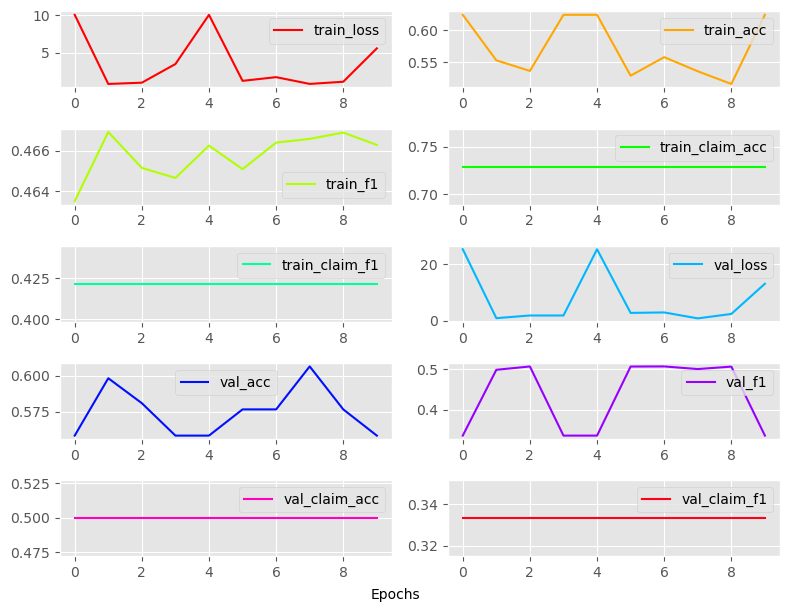

In [174]:
plot_history(bov_mean_model_history, nrows=5, ncols=2)

In [124]:
test(
    bov_mean_model,
    test_dataloader,
    embedding_matrices["test"],
    gt_df[gt_df["split"] == "test"],
)

(0.7041515419078452, 0.4131977260188539)

In [154]:
bov_mean_sim_model = FactCheckingModel(
    EMBEDDING_DIMENSION,
    MAX_TOKENS,
    lr=LEARNING_RATE,
    padding_index=vocabulary.from_string[PADDING_TOKEN],
    sentence_strategy="bov",
    merging_strategy="mean",
    cosine_similarity=True
)
print(f"The model has {bov_mean_sim_model.count_parameters():,} trainable parameters")

The model has 302 trainable parameters


In [155]:
bov_mean_sim_model_history = actual_train_eval(bov_mean_sim_model, "bov_mean_sim_model",)

KeyboardInterrupt: 

In [805]:
mlp_mean_model = FactCheckingModel(
    EMBEDDING_DIMENSION,
    MAX_TOKENS,
    lr=LEARNING_RATE,
    padding_index=vocabulary.from_string[PADDING_TOKEN],
    sentence_strategy="mlp",
    merging_strategy="mean",
)
print(f"The model has {mlp_mean_model.count_parameters():,} trainable parameters")

The model has 22,500,601 trainable parameters


In [806]:
mlp_mean_model_history = actual_train_eval(mlp_mean_model, "mlp_mean_model",)

KeyboardInterrupt: 

In [808]:
rnn_last_mean_model = FactCheckingModel(
    EMBEDDING_DIMENSION,
    MAX_TOKENS,
    num_recurrent_layers=1,
    lr=LEARNING_RATE,
    padding_index=vocabulary.from_string[PADDING_TOKEN],
    sentence_strategy="rnn_last",
    merging_strategy="mean",
)
print(f"The model has {rnn_last_mean_model.count_parameters():,} trainable parameters")

The model has 722,701 trainable parameters


In [809]:
rnn_last_mean_model_history = actual_train_eval(rnn_last_mean_model, "rnn_last_mean_model",)

KeyboardInterrupt: 

## Training

## Evaluation

## Comments/summary